# Estimating Non-Diagonal Maps using Encoders

In [1]:
import sys
sys.path.append("../../../")
sys.path.append('../../')
import os
import time
import json
import torch
from tqdm import tqdm
from itertools import cycle
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
from torch.nn import functional as F
import matplotlib.pyplot as plt


from potential_flows import transforms, potential, encoders, data, flow, data
from flow.arguments import set_seed, parse_arguments, parse_notebook_arguments, get_parser

/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Example 1: Checkerboard Mixture

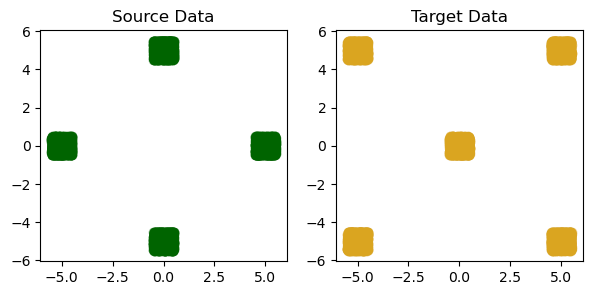

In [9]:
torch.manual_seed(42)
args = parse_notebook_arguments()
args.source_dist = "our_checker"
args.target_dist = "our_checker"
args.verbose = False
args.num_bins = 8

dataset_x, dataset_y = data.get_dataset(args, split = "train")  ## train dataset
test_x, test_y = data.get_dataset(args, split = "test")  ## test dataset
fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1], alpha=.4, color="darkgreen")
axs[0].set_title("Source Data")
axs[1].scatter(dataset_y.data[:,0], dataset_y.data[:,1], alpha=.4, color="goldenrod")
axs[1].set_title("Target Data")
plt.show()

### Dual Method

In [10]:
# creating the flow

tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
potential_flow = potential.ICRQ(tail_bound=tail_bound*args.tail_factor, num_bins=4, data_shape=(2,))

In [11]:
# creating data loaders

data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

# creating OT Trainer

OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)

In [12]:
OT_Trainer.potential_flow = torch.load(OT_Trainer.exp_dir + '/best_flow.t')
# OT_Trainer.learn()

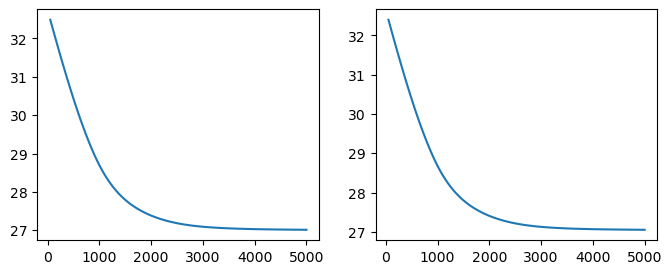

In [13]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

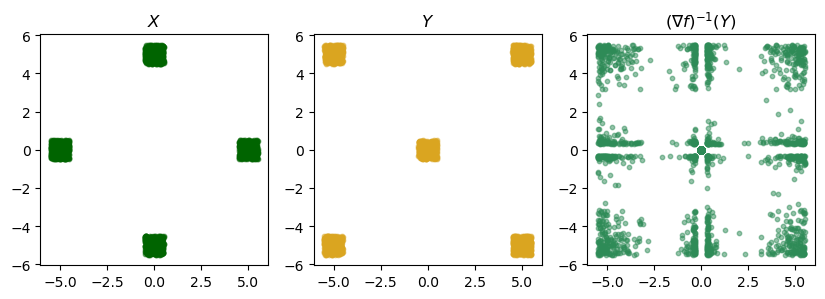

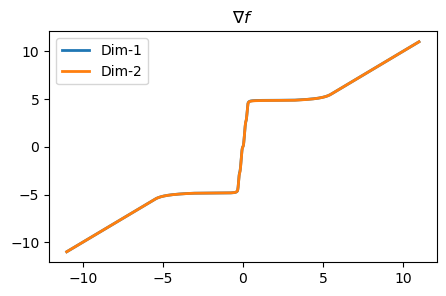

In [14]:
OT_Trainer.args.show_the_plot = True
OT_Trainer.save_figure()
OT_Trainer.args.show_the_plot = False

As expected the diagonal map is unable to transport the checker example considered by Makkuva et. al. Noteice that it succesfully transports the marginals. Therefore, we explore autoencoders, VAE, and PCA to find a latent distributions for source and target distribution that can be transported by diagonal map (using derivative of a ICRQ spline).

#### Principle Component Analysis

Since the proinciple componenets of the checkerboard data are aligned along the x and y axis, PCA leaves the data unchanged. Therefore, we conduct PCA based encoding for banana distribution.

In [15]:
# load dataset

args.source_dist = "banana"
args.target_dist = "gaussian"
dataset_x, dataset_y = data.get_dataset(args, split = "train")  ## train dataset
test_x, test_y = data.get_dataset(args, split = "test")  ## test dataset

# PCA with number of components = 2

n_components = 2
transform_x = encoders.PCA(n_components=n_components).fit(dataset_x.data)
transform_y = encoders.PCA(n_components=n_components).fit(dataset_y.data)

# create flow

tail_bound = args.tail_factor+torch.max(torch.abs(transform_x.encode(dataset_x.data))) + 0.5
potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=6, data_shape=(n_components,))

# data loaders

data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

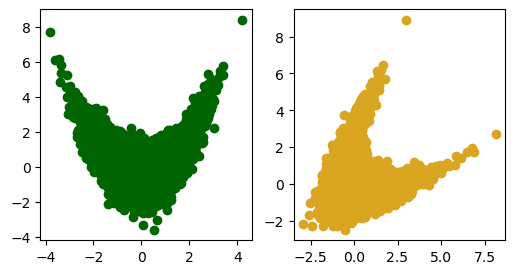

In [16]:
# plot transformed data using PCA

pca_Xtrain = data.CustomDataset(transform_x.encode(dataset_x.data))
fig, axs = plt.subplots(1, 2, figsize = (6,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1], color="darkgreen")
axs[1].scatter(pca_Xtrain.data[:,0], pca_Xtrain.data[:,1], color="goldenrod")

In [22]:
PCA_OT_Trainer = flow.DualPCA_OT_Trainer(potential=potential_flow,
                                    transform_x=transform_x,
                                    transform_y=transform_y,
                                    args=args,
                                    dataset_x=data_loader_X,
                                    dataset_y=data_loader_Y,
                                    test_x=test_x,
                                    test_y=test_y)
                                    
# PCA_OT_Trainer.learn() # uncomment to train

In [29]:
PCA_OT_Trainer.encoder_flow = torch.load(PCA_OT_Trainer.exp_dir+'/best_flow.t')

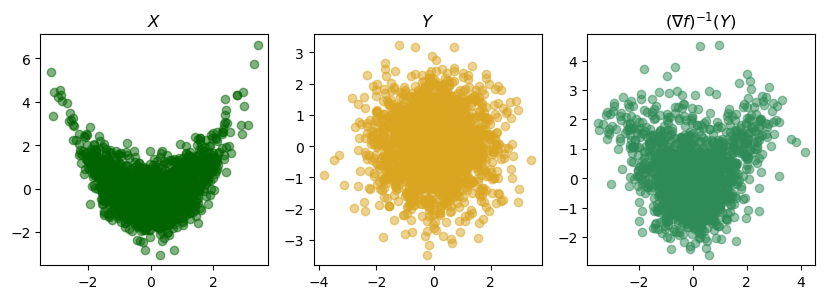

In [30]:
PCA_OT_Trainer.args.show_the_plot = True
PCA_OT_Trainer.generate()

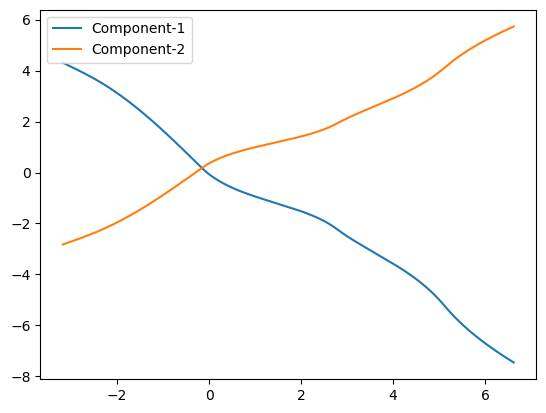

In [31]:
PCA_OT_Trainer.plot_flow()
PCA_OT_Trainer.args.show_the_plot = False

#### Autoencoder Potential Flow

Let us consider the simple case of high dimensional Gaussian and use autoencoders to find a smaller dimensional latent space representation of the source adnd target data. This transformed data is then transported using ICRQ spline based potential flows.

In [2]:
args = parse_notebook_arguments()
args.source_dist = 'gaussian'
args.target_dist = 'gaussian'
d = 1000
args.verbose = False
args.data_shape = (d,)

## create dataset and dataloaders

dataset_x, dataset_y = data.get_dataset(args, split="train")
test_x, test_y = data.get_dataset(args, split="test")
data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)


In [3]:
hidden_dim = 512
latent_dim = 10
tail_bound = 1

# create autoencoders for source and target distribution

ae_x = encoders.AE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)
ae_y = encoders.AE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)

# potential flow

potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=4, data_shape=(latent_dim,))

# train

AE_OT_Trainer = flow.DualAE_OT_Trainer(potential=potential_flow,
                                        transform_x=ae_x,
                                        transform_y=ae_y,
                                        args=args,
                                        dataset_x=data_loader_X,
                                        dataset_y=data_loader_Y,
                                        test_x=test_x,
                                        test_y=test_y)
                                        
# AE_OT_Trainer.learn() # uncomment to learn

In [ ]:
# plotting train and test loss

with open(os.path.join(AE_OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

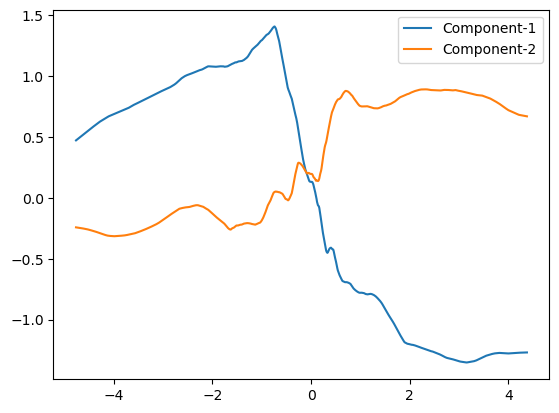

In [13]:
AE_OT_Trainer.args.show_the_plot = True
AE_OT_Trainer.plot_flow()

#### Learning OT using Simple Encoders

We use two encoders $T_1: \mathbb{R}^d \to \mathbb{R}^p $ and $T_2: \mathbb{R}^d \to \mathbb{R}^p $ and minimize the semi-dual loss
$$\min_{f, T_1, T_2}\frac{1}{n} \sum_{i=1}^n \left(f(T_1(X_i)) + f^*(T_2(Y_i))\right)$$

Further we learn two decoders $S_1: \mathbb{R}^p \to \mathbb{R}^d $ and $S_2: \mathbb{R}^p \to \mathbb{R}^d $ by minimizing their respective reconstruction loss with $T_1$ and $T_2$.

In [3]:
hidden_dim = 512
latent_dim = 10
tail_bound = 1
args.show_the_plot = False

# create encoders for source and target distribution

encoder_x = encoders.Encoder(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)
encoder_y = encoders.Encoder(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)

# potential flow

potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=4, data_shape=(latent_dim,))

# train

Encoder_OT_Trainer = flow.DualEncoder_OT_Trainer(potential=potential_flow,
                                            encoder_x=encoder_x,
                                            encoder_y=encoder_y,
                                            args=args,
                                            dataset_x=data_loader_X,
                                            dataset_y=data_loader_Y,
                                            test_x=test_x,
                                            test_y=test_y)
# Encoder_OT_Trainer.learn()

In [4]:
Encoder_OT_Trainer.encoder_flow = torch.load(Encoder_OT_Trainer.exp_dir+'/best_flow.t')

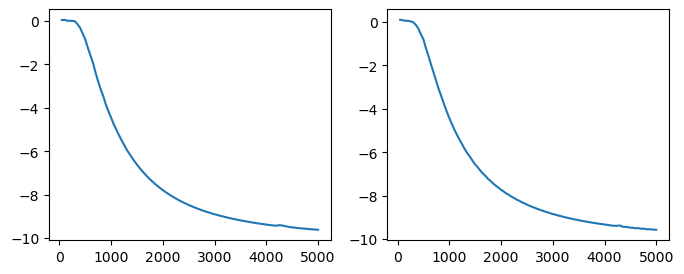

In [5]:
# plotting train and test loss

with open(os.path.join(Encoder_OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

In [6]:
decoder_x, decoder_y, losses_x, losses_y = Encoder_OT_Trainer.learn_decoders(epochs=1000, learning_rate=0.05)

100%|██████████| 1000/1000 [01:38<00:00, 10.20it/s]


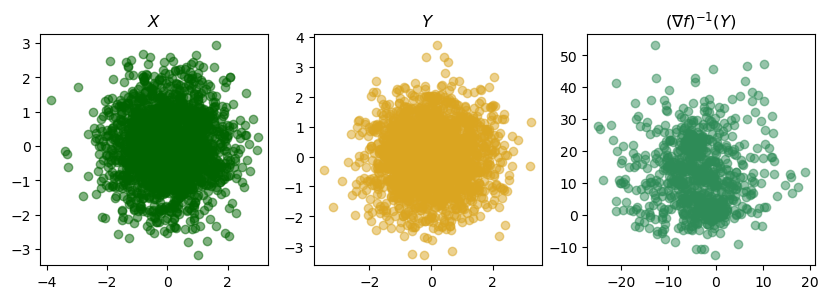

In [38]:
Encoder_OT_Trainer.args.show_the_plot = True
Encoder_OT_Trainer.generate(decoder_x=decoder_x)


In [13]:
x = torch.randn(1,1000)
y = decoder_x(Encoder_OT_Trainer.encoder_flow.encode_x(x))
print(torch.sum((x - y)**2))

tensor(922.5291, grad_fn=<SumBackward0>)


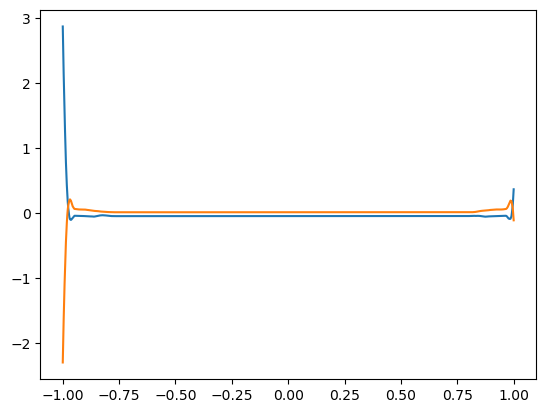

In [20]:
# plot flow

x = torch.linspace(-1, 1, 1000)
x = torch.cat([x.unsqueeze(-1)]*np.prod(Encoder_OT_Trainer.args.data_shape), dim=1)
with torch.no_grad():
    y = Encoder_OT_Trainer.encoder_flow.encode_x(x)
    y = Encoder_OT_Trainer.encoder_flow.potential.gradient(y)
    y = decoder_y(y)
for i in [0,1]:
    plt.plot(x[:,i], y[:,i], label='Component-{}'.format(i+1))


#### Variational Autoencoders

Unfortunately, VAE suffers the same issues as autoencoders.

In [ ]:
hidden_dim = 512
latent_dim = 10
tail_bound = 1

# create autoencoders for source and target distribution

vae_x = encoders.VAE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)
vae_y = encoders.VAE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)

# potential flow

potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=4, data_shape=(latent_dim,))

# train

VAE_OT_Trainer = flow.DualVAE_OT_Trainer(potential=potential_flow,
                                        transform_x=vae_x,
                                        transform_y=vae_y,
                                        args=args,
                                        dataset_x=data_loader_X,
                                        dataset_y=data_loader_Y,
                                        test_x=test_x,
                                        test_y=test_y)
VAE_OT_Trainer.learn()

In [ ]:
VAE_OT_Trainer.args.show_the_plot = True
VAE_OT_Trainer.plot_flow()